# How to use Siphon and Cartopy to visualize data served by a THREDDS Data Server (TDS) via ncWMS

In [1]:
import cartopy
import matplotlib as mpl
import matplotlib.pyplot as plt
from owslib.wms import WebMapService
from siphon.catalog import get_latest_access_url

## Use Siphon to get the latest run of the NCEP 2.5 km HRRR run
 * HRRR => High Resolution Rapid Refresh
  * Temporal output: 1 hour
  * Grid spacing: 2.5 km
  * Roughly 2 GB per run, limited subset of variables actually made available from NCEP to save on bandwidth
 * get the ncWMS access point
 * use owslib's WebMapService to connect to the ncWMS endpoint

In [2]:
catalog = 'http://thredds-jumbo.unidata.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km/catalog.xml'
serverurl = get_latest_access_url(catalog, 'WMS')

wms = WebMapService( serverurl, version='1.1.1')

## List the avaliable layers in the dataset

In [3]:
#Listing all available layers...
layers = list(wms.contents)
for layer in layers:
    print('Layer name: {}'.format(wms[layer].name))

Layer name: Best_4-layer_lifted_index_pressure_difference_layer
Layer name: u-component_storm_motion_height_above_ground_layer
Layer name: wind @ Isobaric surface
Layer name: Categorical_ice_pellets_surface
Layer name: Temperature_isobaric
Layer name: u-component_of_wind_isobaric
Layer name: Convective_available_potential_energy_surface
Layer name: Echo_top_cloud_tops
Layer name: Snow_depth_surface
Layer name: Water_equivalent_of_accumulated_snow_depth_surface_1_Hour_Accumulation
Layer name: Wind_speed_gust_surface
Layer name: v-component_of_wind_isobaric
Layer name: Total_precipitation_surface_1_Hour_Accumulation
Layer name: Wind_speed_height_above_ground_1_Hour_Maximum
Layer name: Pressure_reduced_to_MSL_msl
Layer name: Dewpoint_temperature_height_above_ground
Layer name: Convective_inhibition_surface
Layer name: Geopotential_height_adiabatic_condensation_lifted
Layer name: Hourly_Maximum_of_Upward_Vertical_Velocity_in_the_lowest_400hPa_pressure_difference_layer_1_Hour_Maximum
Layer 

## Get the "Temperature_height_above_ground" layer
 * What is the "height_above_ground"?
 * Cannot automagically get the range, so use 273 K to 315 K

In [4]:
temp = wms['Temperature_height_above_ground']

elevations = [elevation.strip() for elevation in temp.elevations]
print(elevations)
# only one elevation, so use it
elevation = elevations[0]
# have to guess the range
color_max = 315  # K
color_min = 273  # K
colorscalerange = '{},{}'.format(color_min,color_max)

['2.0']


## List the available times and choose the first

In [5]:
times = [time.strip() for time in temp.timepositions]
print(times)
# get the first time - Forecast Hour 0
time = times[0]

['2015-07-03T15:00:00.000Z', '2015-07-03T16:00:00.000Z', '2015-07-03T17:00:00.000Z', '2015-07-03T18:00:00.000Z', '2015-07-03T19:00:00.000Z', '2015-07-03T20:00:00.000Z', '2015-07-03T21:00:00.000Z', '2015-07-03T22:00:00.000Z', '2015-07-03T23:00:00.000Z', '2015-07-04T00:00:00.000Z', '2015-07-04T01:00:00.000Z', '2015-07-04T02:00:00.000Z', '2015-07-04T03:00:00.000Z', '2015-07-04T04:00:00.000Z', '2015-07-04T05:00:00.000Z', '2015-07-04T06:00:00.000Z']


## Use the information from above and Cartopy to plot the layer
 * Note that ncWMS is not returning a data array, but rather an image, so this is relatively "fast" (a quick preview)
 * The tradeoff is that you cannot do computational analysis using ncWMS

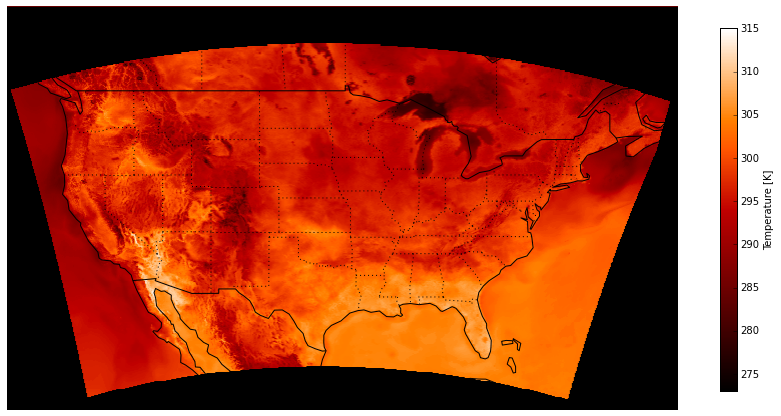

In [6]:
# pick a projection - going with Miller for this example
# note that with Cartopy you are NOT limited to the projections avaliable through ncWMS
plt_proj = cartopy.crs.Miller()

fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': plt_proj})

# Colorbar goodness
cax = fig.add_axes([0.95, 0.3, 0.02, 0.42])
norm = plt.Normalize(vmin=color_min, vmax=color_max)
cmap = plt.cm.gist_heat
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
cb.set_label('Temperature [K]')

# use bounding box info obtained from the ncWMS service to frame the image
extent = (temp.boundingBox[0], temp.boundingBox[2], temp.boundingBox[1], temp.boundingBox[3])
ax.set_extent(extent)

# ncWMS keywords (which includes the WMS keywords as well)
wms_kwargs = {'colorscalerange': colorscalerange,
              'abovemaxcolor': 'transparent',
              'belowmincolor': 'transparent',
              'transparent': 'true',
              'elevation': elevation,
              'time': time}

# plot the layer using Cartopy's WMS interface
ax.add_wms(wms=serverurl, layers=[temp.name], wms_kwargs=wms_kwargs, cmap=cmap)

# add coastlines, country borders and state outlines
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'), linestyle=':')